In [99]:
# Structure
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import random

In [24]:
df = pd.read_csv('df_cluster_05_01_pca_num_5.csv')
df_pca = pd.read_csv('pca_df_cluster_05_01_pca_num_5.csv')
# cluster 열 대치
df['cluster'] = df_pca['cluster']

df = df.iloc[:,1:]
# load the raw data
raw_df = pd.read_csv('data_sample.csv')

# genre 열 추가
df = pd.merge(df, raw_df[['video_url', 'genre']], on='video_url')
df.columns

Index(['views', 'likes', 'ads_yn', 'duration_seconds', 'subscribers',
       'totalViews', 'ch_avg_views', 'genre_weight', 'date_from_recent',
       'date_from_recent_week', 'cluster', 'video_url', 'title', 'channel_id',
       'genre'],
      dtype='object')

In [25]:
# Shorts 여부 컬럼 추가
df['shorts'] = df['duration_seconds'] < 60
df['shorts'] = df['shorts'].astype('int')

# Visualization

## 영상의 개수

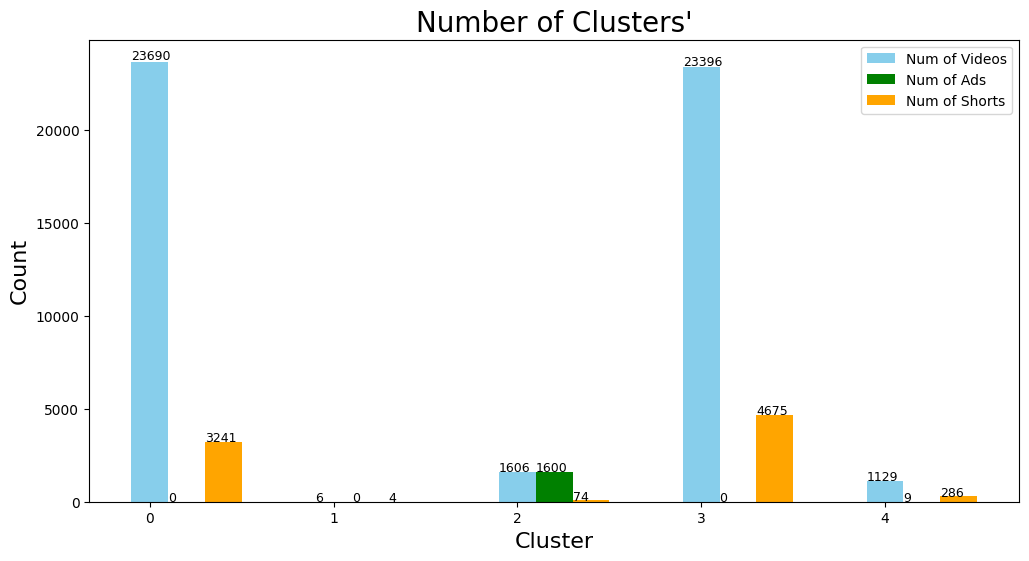

,총 영상 개수,유료광고 영상 개수,숏츠 영상 개수
cluster,,,
0,23690,0,3241
1,6,0,4
2,1606,1600,74
3,23396,0,4675
4,1129,9,286


In [27]:

df_grouped = df.groupby('cluster')
video_url_counts = df_grouped['video_url'].count()
ads_yn_counts = df_grouped['ads_yn'].apply(lambda x: x[x == 1].count())
shorts_counts = df_grouped['shorts'].apply(lambda x: x[x == 1].count())

# 막대 그래프를 그립니다.

fig, ax = plt.subplots(figsize=(12,6))
bar_width = 0.2

bar1 = ax.bar(video_url_counts.index, video_url_counts, bar_width, color='skyblue', label='Num of Videos')
bar2 = ax.bar(ads_yn_counts.index + bar_width, ads_yn_counts, bar_width, color='green', label='Num of Ads')
bar3 = ax.bar(shorts_counts.index + 2*bar_width, shorts_counts, bar_width, color='orange', label='Num of Shorts')


plt.title("Number of Clusters'", fontsize=20)
plt.xlabel('Cluster', fontsize=16)
plt.ylabel('Count', fontsize=16)

# 숫자 추가
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.005), fontsize=9)

ax.legend(fontsize=10)
plt.show()
# 데이터프레임으로 표로 만듦
num_df = pd.DataFrame({"총 영상 개수": df_grouped['video_url'].count(),
                      "유료광고 영상 개수": ads_yn_counts,
                      "숏츠 영상 개수": shorts_counts})
num_df

In [28]:
# 1번 클러스터는 예외적으로 다루기 위해
cluster1_df = df[df['cluster']==1]

In [76]:
# 1번 클러스터만 분리
ex1_df = df[df['cluster']!=1]
ex1_df['cluster'].unique()
df_grouped_ex1 = ex1_df.groupby('cluster')

# Numerical Features


## Median 시각화

In [96]:
n_features=['views', 'likes', 'duration_seconds', 'subscribers','totalViews', 'ch_avg_views']
median_df = df_grouped_ex1[n_features].median()
median_df

,views,likes,duration_seconds,subscribers,totalViews,ch_avg_views
cluster,,,,,,
0,2142.5,23.0,435.0,36500.0,1.187340e+07,11710.5
2,11450.0,117.5,671.0,72800.0,2.700391e+07,38878.0
3,1776.0,22.0,320.0,40400.0,1.239485e+07,14052.5
4,38724.0,513.0,208.0,3110000.0,2.147484e+09,358210.0


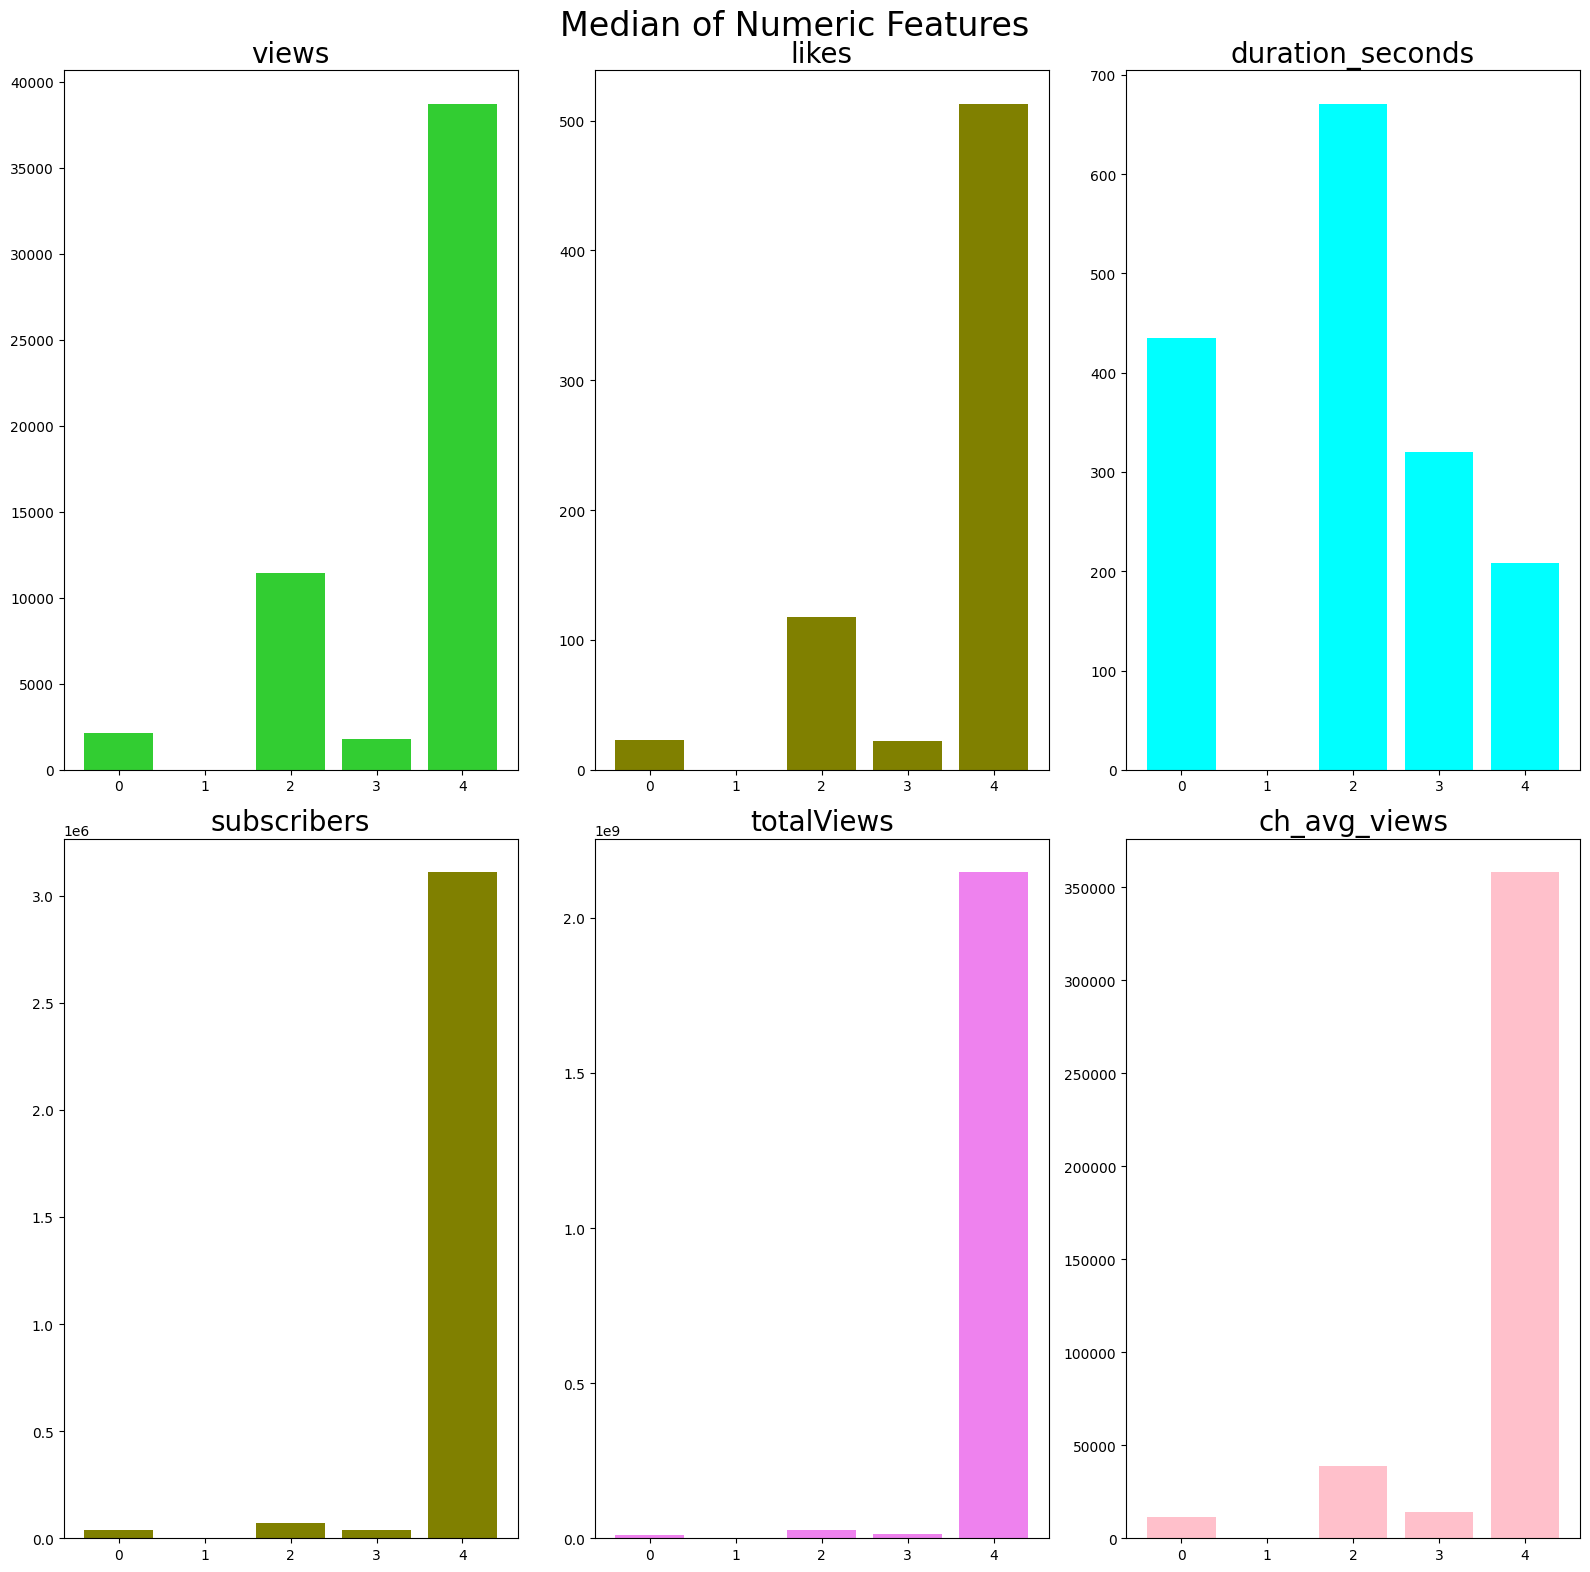

In [160]:
# Figure와 Subplots 생성
fig, axs = plt.subplots(2, 3, figsize=(16, 16))
colors = ['limegreen', 'violet', 'dodgerblue','gold', 'khaki', 'cyan', 'pink', 'coral', 'teal', 'purple', 'olive']
plt.suptitle('Median of Numeric Features', fontsize=24)
# 각 서브플롯에 막대그래프 그리기
axs[0, 0].bar(median_df.index, median_df['views'], color=random.choice(colors))
axs[0, 0].set_title('views', fontsize=20)

axs[0, 1].bar(median_df.index, median_df['likes'], color=random.choice(colors))
axs[0, 1].set_title('likes', fontsize=20)

axs[0, 2].bar(median_df.index, median_df['duration_seconds'], color=random.choice(colors))
axs[0, 2].set_title('duration_seconds', fontsize=20)

axs[1, 0].bar(median_df.index, median_df['subscribers'], color=random.choice(colors))
axs[1, 0].set_title('subscribers', fontsize=20)

axs[1, 1].bar(median_df.index, median_df['totalViews'], color=random.choice(colors))
axs[1, 1].set_title('totalViews', fontsize=20)

axs[1, 2].bar(median_df.index, median_df['ch_avg_views'], color=random.choice(colors))
axs[1, 2].set_title('ch_avg_views', fontsize=20)

# 각 서브플롯 간의 간격 조정
plt.tight_layout()

# 그래프 보여주기
plt.show()

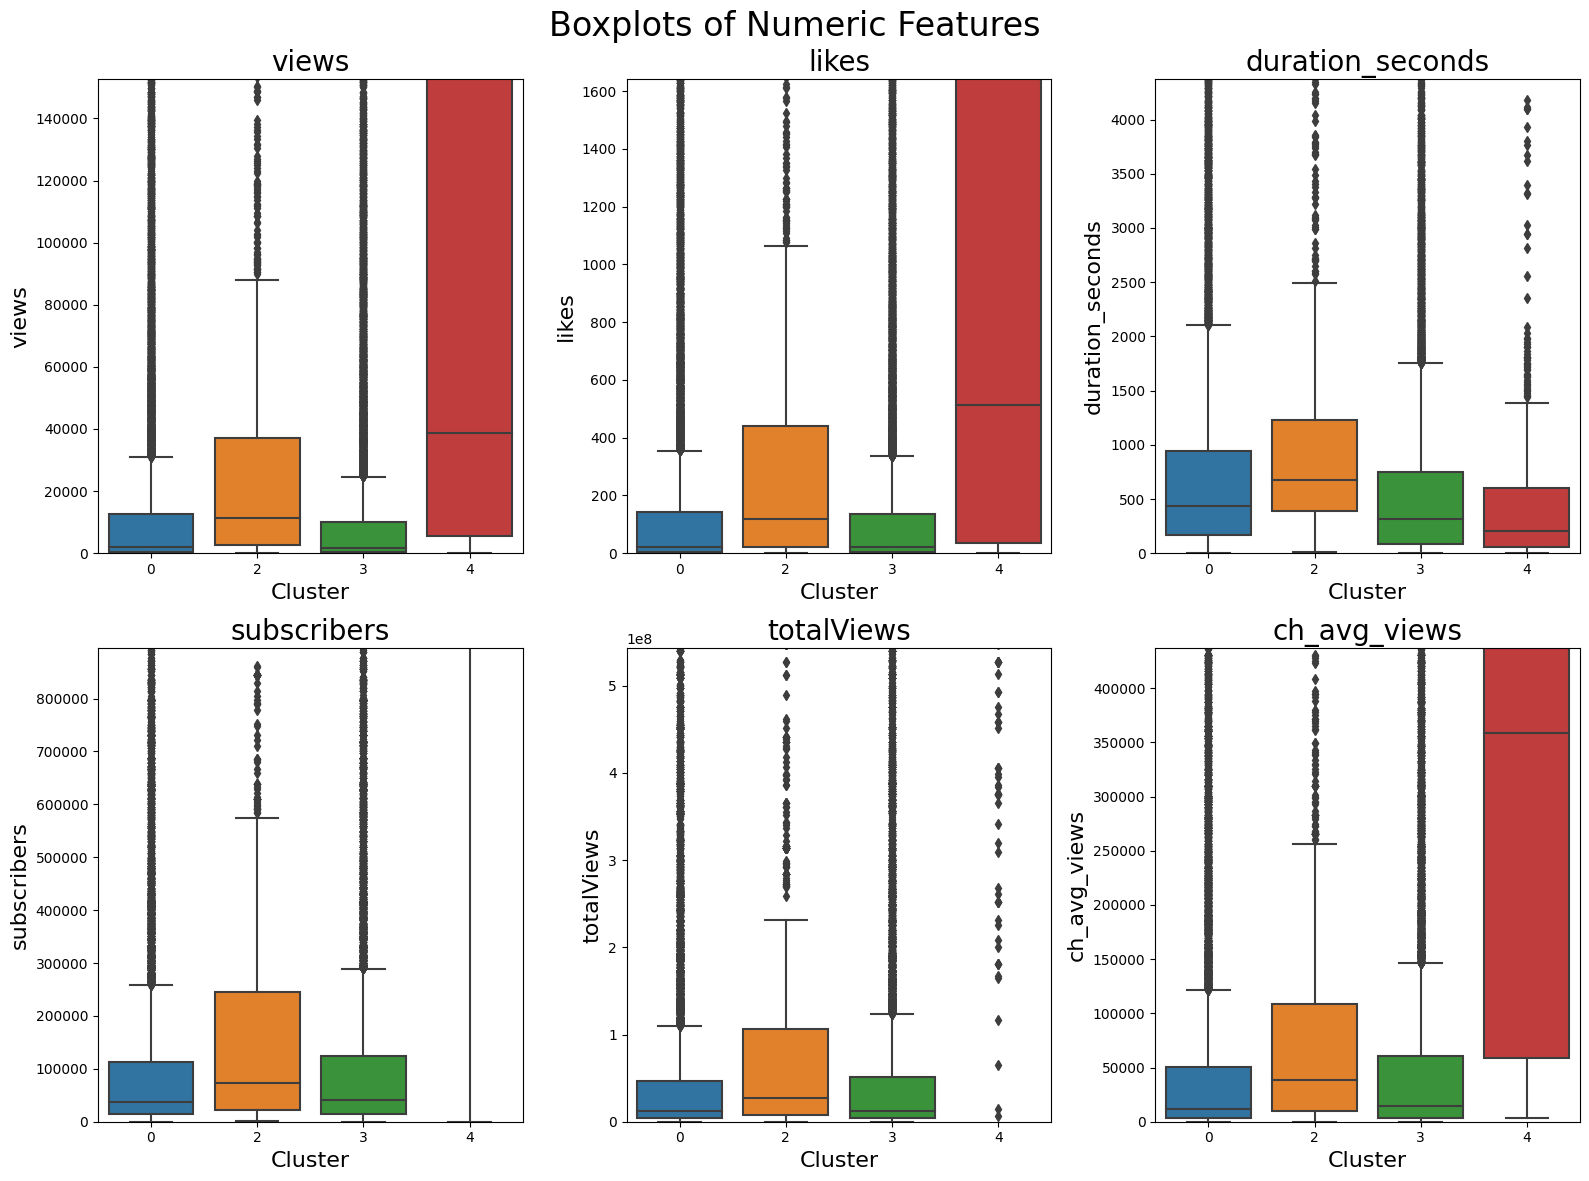

In [148]:
# Figure와 Subplots 생성
fig, axs = plt.subplots(2, 3, figsize=(16, 12))
plt.suptitle('Boxplots of Numeric Features', fontsize=24)
# numeric value에 대한 boxplot
for i, var in enumerate(n_features):
    row = i // 3
    col = i % 3
    sns.boxplot(x='cluster', y=var, data=ex1_df, ax=axs[row, col])
    axs[row, col].set_title(f"{var}", fontsize=20)
    axs[row, col].set_xlabel('Cluster', fontsize=16)
    axs[row, col].set_ylabel(var, fontsize=16)
    y_max = ex1_df[var].quantile(0.95)  # 0.95 quantile used as an example
    axs[row, col].set_ylim(0, y_max)

# 각 서브플롯 간의 간격 조정
plt.tight_layout()

# 그래프 보여주기
plt.show()

## 이상치 제거

In [170]:
# iterate over all unique clusters
for cluster in ex1_df['cluster'].unique():
    # select the part of the dataframe that corresponds to the current cluster
    cluster_df = ex1_df[ex1_df['cluster'] == cluster]
    
    # iterate over all numeric features
    for feature in n_features:
        # calculate the IQR
        Q1 = cluster_df[feature].quantile(0.25)
        Q3 = cluster_df[feature].quantile(0.75)
        IQR = Q3 - Q1

        # define outliers
        outlier_condition = (cluster_df[feature] < (Q1 - 1.5 * IQR)) | (cluster_df[feature] > (Q3 + 1.5 * IQR))

        # replace outliers with NaN
        cluster_df.loc[outlier_condition, feature] = np.nan

    # update the original dataframe with the cleaned data from the current cluster
    new_ex1_df = ex1_df.update(cluster_df)

# drop rows with NaN values (i.e., outliers)
#ex1_df.dropna(subset=numeric_features, inplace=True)

In [176]:
cluster_df

,views,likes,ads_yn,duration_seconds,subscribers,totalViews,ch_avg_views,genre_weight,date_from_recent,date_from_recent_week,cluster,video_url,title,channel_id,genre,shorts
30,76740.0,NaN,1,1217.0,NaN,NaN,61789.0,0.07442,42.0,6.0,2,https://www.youtube.com/watch?v=egG2mmLrTGA,"BoA 무서운 경고 ""2028년 중국 GDP가 미국을 추월 할 것"" / 금 관리 들...",UCCG6BEYjfQMGzypJw2EJCDQ,Howto & Style,0
87,NaN,NaN,1,232.0,NaN,NaN,111355.0,0.04292,111.0,15.0,2,https://www.youtube.com/watch?v=3X5YOC8TuHI,17472회. 그렇게 해서 부자 되겠습니까? (휴게소에서 생긴 일),UCH5U89kvHrVxxS80xpoOydw,Autos & Vehicles,0
136,892.0,0.0,1,61.0,13700.0,3497282.0,3007.0,0.09326,36.0,5.0,2,https://www.youtube.com/watch?v=ZRTh6cKXBJU,라울 꽃대 뽑아주세요. #박시연다육 #국민이다육,UCYRjsm8xHlJveo_RAHzyAbQ,People & Blogs,0
220,31177.0,0.0,1,524.0,51100.0,90979320.0,23197.0,0.22918,128.0,18.0,2,https://www.youtube.com/watch?v=YudFiXyQ7pQ,[렌] [리니지M] 이 형은 진짜 뭐지... 연금에 진심인데? 풀컬렉 노린다구요? ...,UC1P1pSjj0D_4bX2RteQLyuA,Gaming,0
225,1262.0,45.0,1,NaN,10000.0,1045676.0,4166.0,0.08650,161.0,23.0,2,https://www.youtube.com/watch?v=kWl4seW2qDQ,숨어서 몰래 먹던 다이어트 커팅제 공개? [22.09.26 #2],UCJxGt5DQpT8aG-Ist4zWaBg,Entertainment,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49641,2922.0,32.0,1,386.0,20900.0,14205321.0,8851.0,0.22918,30.0,4.0,2,https://www.youtube.com/watch?v=EOSwsBNcIb4,[히트2] 골드로 다이아버는 절대 추천하지 않는방법,UC4tQqXb9fG8_xexCbTp2bjQ,Gaming,0
49664,75283.0,957.0,1,796.0,483000.0,NaN,45492.0,0.22918,136.0,19.0,2,https://www.youtube.com/watch?v=6DDcgWWTqIU,오랜만에 조카랑 놀아주는 삼촌들,UCyHvSKT_bLDYpkv1JjjsLAg,Gaming,0
49686,NaN,NaN,1,1114.0,NaN,197779848.0,NaN,0.07442,116.0,16.0,2,https://www.youtube.com/watch?v=rGoDNiEQd5A,일주일 동안 먹은 맛있는 집밥 7가지 / 맛있는 집밥을 위한 살림템 추천,UCg_xrQ9KMN7wL4moBwuxZWw,Howto & Style,0
49782,1819.0,46.0,1,536.0,8630.0,1948322.0,3178.0,0.22918,173.0,24.0,2,https://www.youtube.com/watch?v=sy_GtUr50nw,"[리니지M] ""어이~ 강프로 층줌은 잡쉈고??"" 오만의탑 층줌 멸망전 [대박TV] ...",UCdX0dzh32J2CU52AlB-ABmg,Gaming,0
